In [174]:
import pandas as pd
import numpy as np

from autots import AutoTS
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

import pickle

import warnings
warnings.filterwarnings('ignore')

In [175]:
# encoding = 'CP949'
filename = 'gasoline_price.csv'
filename1 = 'brent_price.csv'
data = pd.read_csv(filename)
data_brent = pd.read_csv(filename1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   구분      5708 non-null   object 
 1   서울      5708 non-null   float64
dtypes: float64(1), object(1)
memory usage: 89.3+ KB


In [176]:
data_brent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4037 entries, 0 to 4036
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기간      4037 non-null   object 
 1   Brent   4029 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.2+ KB


## 2. Data Preparation

Gasoline data

In [177]:
"""Date format preprocessing"""
char_replace = ['년', '월']

for char in char_replace:
    data['구분'] = data['구분'].str.replace(char, '-')

data['구분'] = data['구분'].str.replace('일', '')
#data['구분'] = data['구분'].str[:-1]

data.rename({'구분':'Day'}, axis=1, inplace = True)

data['Date'] = pd.to_datetime(data['Day'], errors='coerce', format='%Y-%m-%d')

data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

data.reset_index(inplace=True)

data = data.drop('Day', axis = 1)

In [178]:
"""Drop last row of Gasoline data to match the data"""
data = data[:-1]

Brent data

In [179]:
'''Change date format of Brent oil data to yyyy-mm-dd'''
data_brent['기간'] = '20' + data_brent.loc[:,'기간']

In [180]:
char_replace = ['년', '월']

for char in char_replace:
    data_brent['기간'] = data_brent['기간'].str.replace(char, '-')

data_brent['기간'] = data_brent['기간'].str.replace('일', '')
#data['구분'] = data['구분'].str[:-1]

data_brent.rename({'기간':'Day'}, axis=1, inplace = True)

data_brent['Date'] = pd.to_datetime(data_brent['Day'], errors='coerce',
                              format='%Y-%m-%d')

data_brent.set_index('Date', inplace=True)
data_brent.sort_index(inplace=True)

data_brent.reset_index(inplace=True)

data_brent = data_brent.drop('Day', axis = 1)

In [181]:
# using the resample method
data_brent.set_index(data_brent.Date, inplace=True)
data_brent = data_brent.resample('D').sum().fillna(0)
data_brent.reset_index(inplace=True)

In [182]:
data.info

<bound method DataFrame.info of            Date       서울
0    2008-04-15  1734.58
1    2008-04-16  1749.97
2    2008-04-17  1744.71
3    2008-04-18  1748.01
4    2008-04-19  1748.87
...         ...      ...
5702 2023-11-25  1730.41
5703 2023-11-26  1729.95
5704 2023-11-27  1730.44
5705 2023-11-28  1727.37
5706 2023-11-29  1723.48

[5707 rows x 2 columns]>

In [183]:
data_brent.info

<bound method DataFrame.info of            Date   Brent
0    2008-04-15  111.31
1    2008-04-16  112.66
2    2008-04-17  112.43
3    2008-04-18  113.92
4    2008-04-19    0.00
...         ...     ...
5702 2023-11-25    0.00
5703 2023-11-26    0.00
5704 2023-11-27   79.98
5705 2023-11-28   81.68
5706 2023-11-29   83.10

[5707 rows x 2 columns]>

- Changing currency(USD to KRW)

In [184]:
print(data_brent.isnull().sum())

Date     0
Brent    0
dtype: int64


- Replace 0 data(weekend data) with previous non zero values in Brent oil Price

In [185]:
data_brent['Brent'].replace(to_replace=0, method='ffill')

0       111.31
1       112.66
2       112.43
3       113.92
4       113.92
         ...  
5702     80.58
5703     80.58
5704     79.98
5705     81.68
5706     83.10
Name: Brent, Length: 5707, dtype: float64

- Rename Gasoline Price data

In [186]:
data.rename(columns = {'서울' : 'Gasoline'}, inplace=True)

In [187]:
data.head(3)

Date  Gasoline
0 2008-04-15   1734.58
1 2008-04-16   1749.97
2 2008-04-17   1744.71

In [188]:
data_brent.head(3)

Date   Brent
0 2008-04-15  111.31
1 2008-04-16  112.66
2 2008-04-17  112.43

## 3. EDA

In [189]:
print(data.isnull().sum())

Date        0
Gasoline    0
dtype: int64


In [190]:
print(data_brent.isnull().sum())

Date     0
Brent    0
dtype: int64


### Visualization (Gasoline)

In [191]:
fig = px.line(data, x='Date', y='Gasoline', title = 'Gasoline Prices of Seoul by Year',
              labels = {
                  "Date" : "Year",
                  "Gasoline" : "Gasoline Price (won)"
              },
              template = 'plotly_dark')
fig.show()

In [193]:
fig = px.histogram(data, x='Gasoline', 
                   title = 'Gasoline Prices of Seoul',
                   labels = {
                  "Gasoline" : "Gasoline Price (won)"
                   },
                   template = 'plotly_dark')
fig.show()

Text(0.5, 0, 'Date')

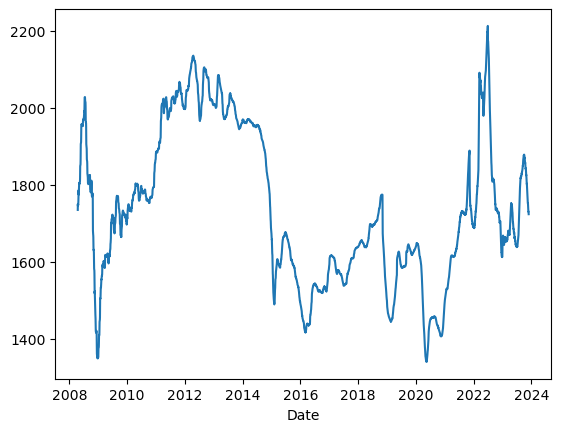

In [194]:
plt.plot(data['Date'], data.loc[:, data.columns != 'Date'])
plt.xlabel("Date")

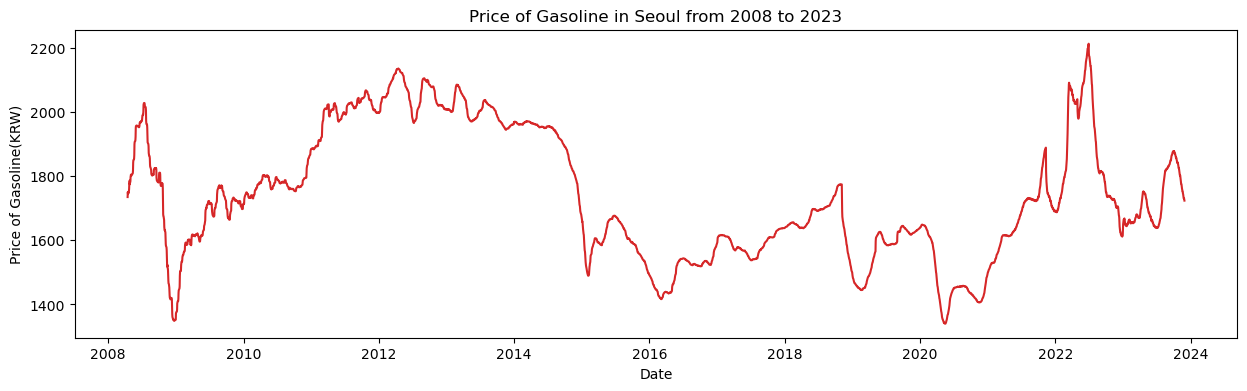

In [195]:
#dpi = 100
plt.figure(figsize=(15,4))#, dpi=dpi)
plt.plot(data['Date'], data['Gasoline'], color='tab:red')
plt.xlabel('Date')
plt.ylabel('Price of Gasoline(KRW)')
plt.title('Price of Gasoline in Seoul from 2008 to 2023')
         
plt.show()

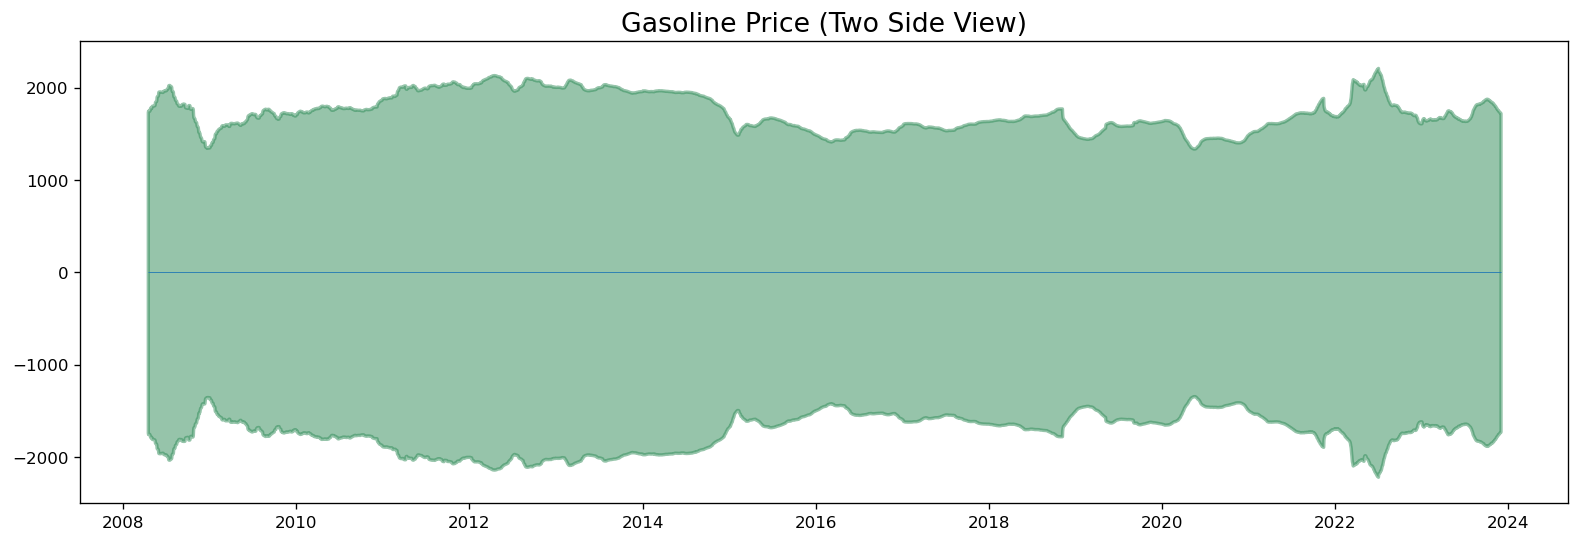

In [196]:
x = data['Date'].values
y1 = data['Gasoline'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-2500, 2500)
plt.title('Gasoline Price (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(data['Date']), xmax=np.max(data['Date']), linewidth=.5)
plt.show()

### Visualization (Brent oil)

In [207]:
fig = px.line(data_brent, x='Date', y='Brent', title = 'Brent oil Prices',
              labels = {
                  "Date" : "Year",
                  "Brent" : "Brent oil Price (usd)"
              },
              template = 'plotly_dark')
fig.show()

In [208]:
fig = px.histogram(data_brent, x='Brent', 
                   title = 'Brent oil Price',
                   labels = {
                  "Brent" : "Brent oil Price (usd)"
                   },
                   template = 'plotly_dark')
fig.show()

Text(0.5, 0, 'Date')

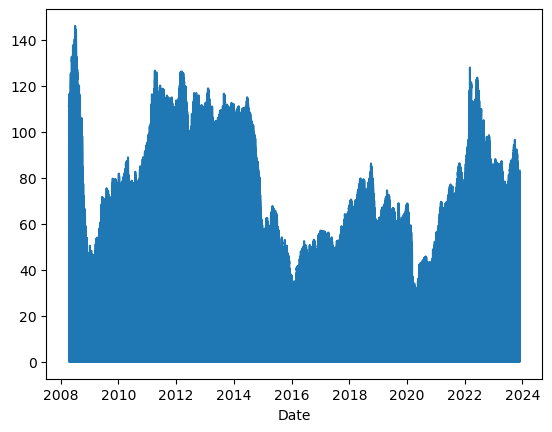

In [200]:
plt.plot(data_brent['Date'], data_brent.loc[:, data_brent.columns != 'Date'])
plt.xlabel("Date")

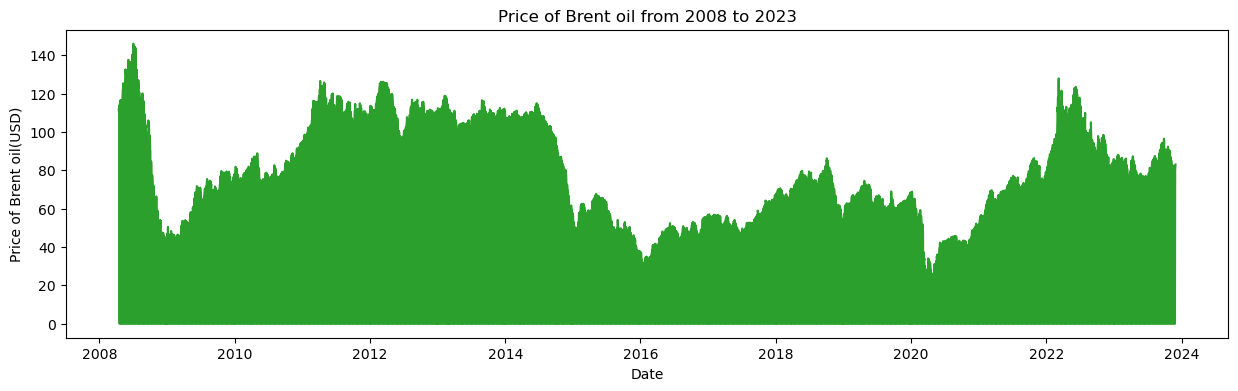

In [209]:
#dpi = 100
plt.figure(figsize=(15,4))#, dpi=dpi)
plt.plot(data_brent['Date'], data_brent['Brent'], color='tab:green')
plt.xlabel('Date')
plt.ylabel('Price of Brent oil(USD)')
plt.title('Price of Brent oil from 2008 to 2023')
         
plt.show()

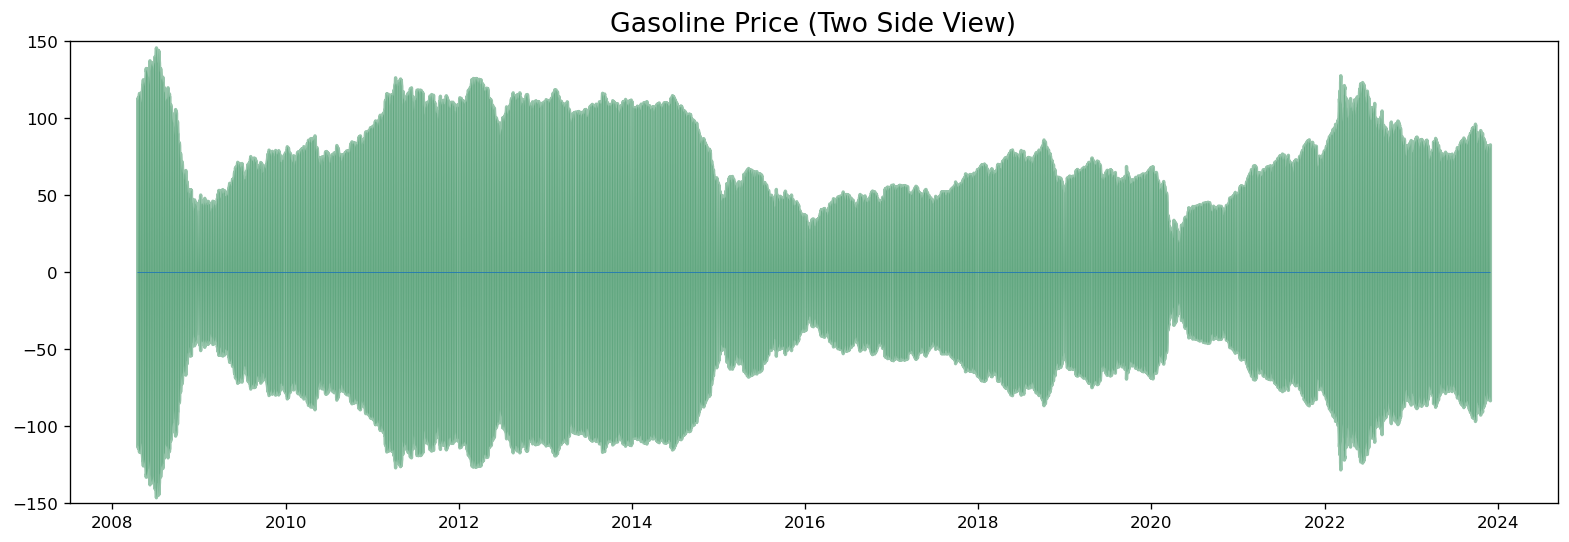

In [206]:
x = data_brent['Date'].values
y1 = data_brent['Brent'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-150, 150)
plt.title('Gasoline Price (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(data['Date']), xmax=np.max(data['Date']), linewidth=.5)
plt.show()

##### Heatmap (Gasoline)

In [210]:
data['year'] = data['Date'].dt.year
data['month'] = seoul['Date'].dt.month
data['day'] = data['Date'].dt.day

In [211]:
data.head(3)

Date  Gasoline  year  month  day
0 2008-04-15   1734.58  2008      4   15
1 2008-04-16   1749.97  2008      4   16
2 2008-04-17   1744.71  2008      4   17

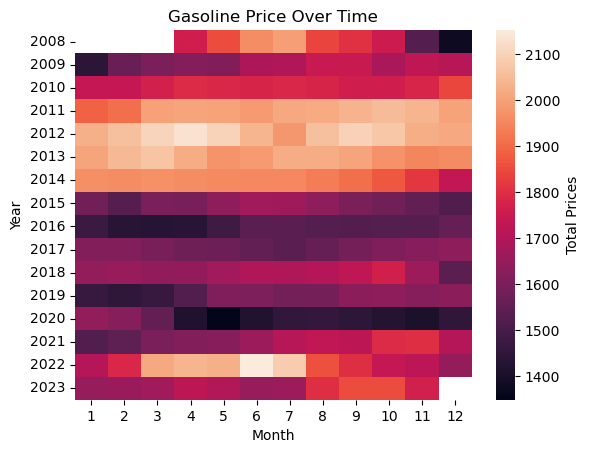

In [212]:
# re-format the data for the heat-map
price_month_year = data.pivot_table(index="year", columns="month", values="Gasoline", aggfunc='mean')

# create heatmap
sns.heatmap(price_month_year, cbar_kws={"label": "Total Prices"})
plt.title("Gasoline Price Over Time")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

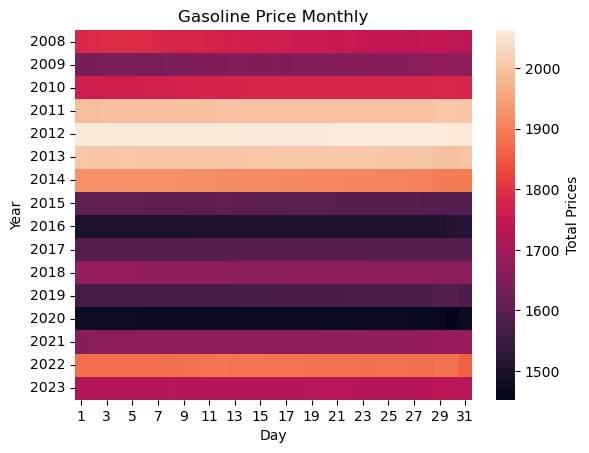

In [213]:
# re-format the data for the heat-map
price_month_day = data.pivot_table(index="year", columns="day", values="Gasoline", aggfunc='mean')

# create heatmap
sns.heatmap(price_month_day, cbar_kws={"label": "Total Prices"})
plt.title("Gasoline Price Monthly")
plt.xlabel("Day")
plt.ylabel("Year")
plt.show()

연도별 가격이 어느 정도였는지 대략 알 수 있다.

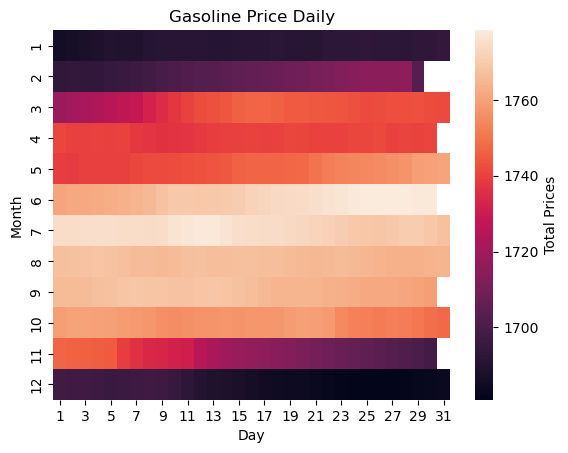

In [215]:
# re-format the data for the heat-map
price_month_day = data.pivot_table(index="month", columns="day", values="Gasoline", aggfunc='mean')

# create heatmap
sns.heatmap(price_month_day, cbar_kws={"label": "Total Prices"})
plt.title("Gasoline Price Daily")
plt.xlabel("Day")
plt.ylabel("Month")
plt.show()

겨울에는 비교적 가격이 하락하고 여름과 가을에 가격이 상승하는 경향을 볼 수 있다.

#### Heatmap (Brent oil)

In [216]:
data_brent['year'] = data_brent['Date'].dt.year
data_brent['month'] = data_brent['Date'].dt.month
data_brent['day'] = data_brent['Date'].dt.day

In [217]:
data_brent.head(3)

Date   Brent  year  month  day
0 2008-04-15  111.31  2008      4   15
1 2008-04-16  112.66  2008      4   16
2 2008-04-17  112.43  2008      4   17

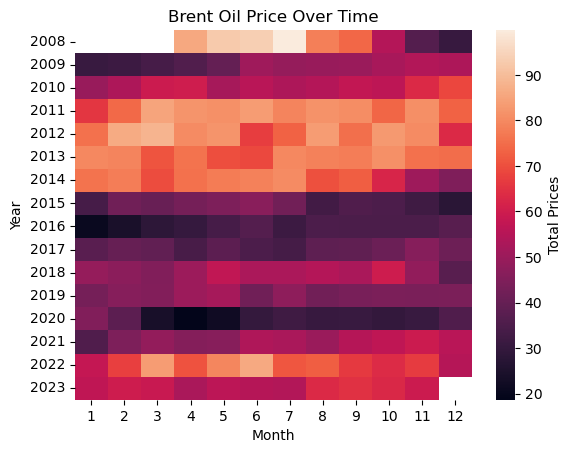

In [218]:
# re-format the data for the heat-map
price_month_year = data_brent.pivot_table(index="year", columns="month", values="Brent", aggfunc='mean')

# create heatmap
sns.heatmap(price_month_year, cbar_kws={"label": "Total Prices"})
plt.title("Brent Oil Price Over Time")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

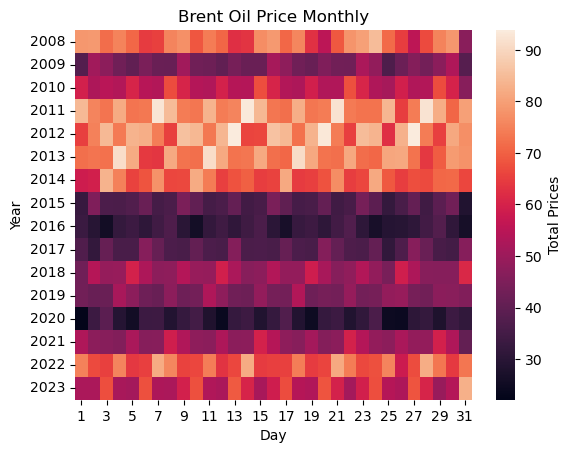

In [219]:
# re-format the data for the heat-map
price_month_day = data_brent.pivot_table(index="year", columns="day", values="Brent", aggfunc='mean')

# create heatmap
sns.heatmap(price_month_day, cbar_kws={"label": "Total Prices"})
plt.title("Brent Oil Price Monthly")
plt.xlabel("Day")
plt.ylabel("Year")
plt.show()

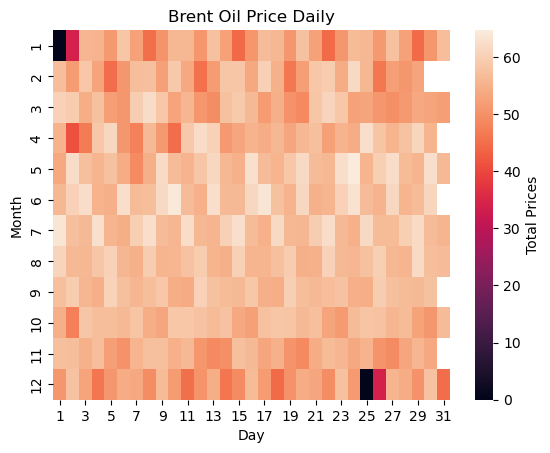

In [220]:
# re-format the data for the heat-map
price_month_day = data_brent.pivot_table(index="month", columns="day", values="Brent", aggfunc='mean')

# create heatmap
sns.heatmap(price_month_day, cbar_kws={"label": "Total Prices"})
plt.title("Brent Oil Price Daily")
plt.xlabel("Day")
plt.ylabel("Month")
plt.show()

##### Lag scatter plot

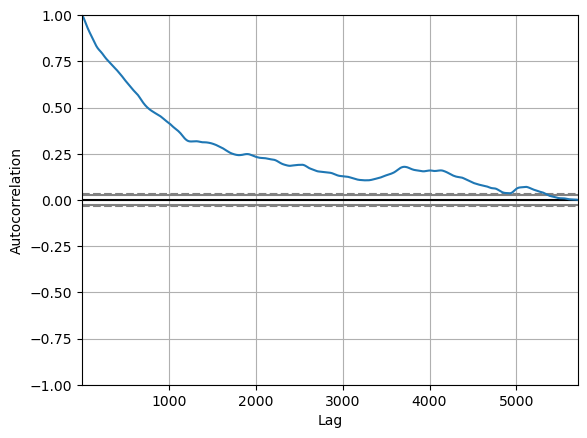

In [221]:
# import autocorrelation function
from pandas.plotting import autocorrelation_plot

year_data = data[['year', 'Gasoline']]

# autocorrelation plot
autocorrelation_plot(year_data)
plt.show()

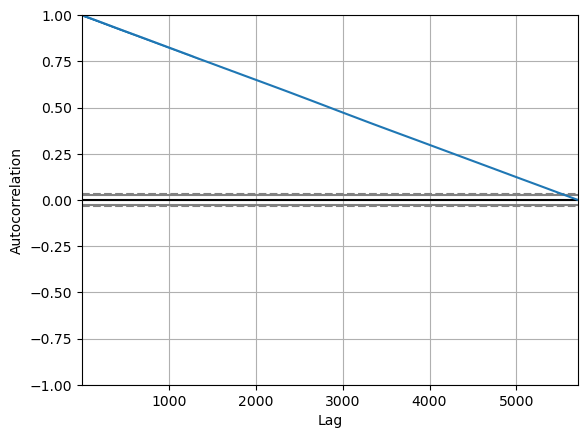

In [222]:
year_dataB = data_brent[['year', 'Brent']]

# autocorrelation plot
autocorrelation_plot(year_dataB)
plt.show()

## Decomposition of a Time Series

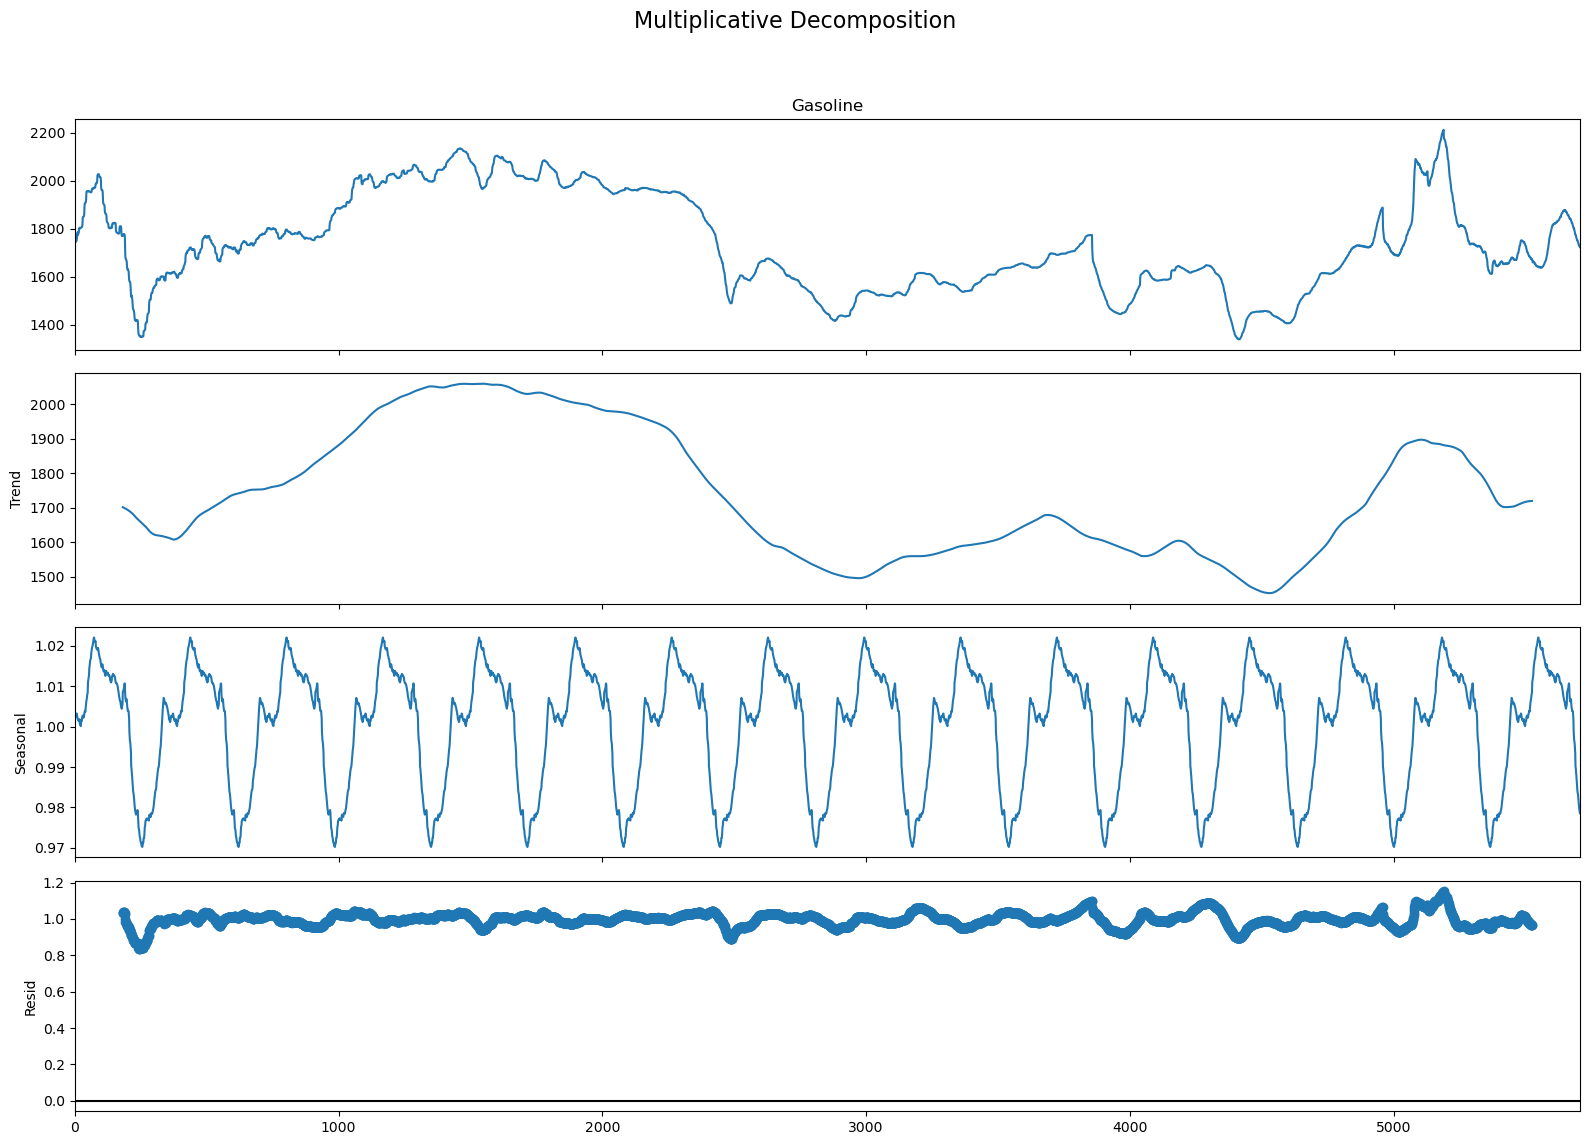

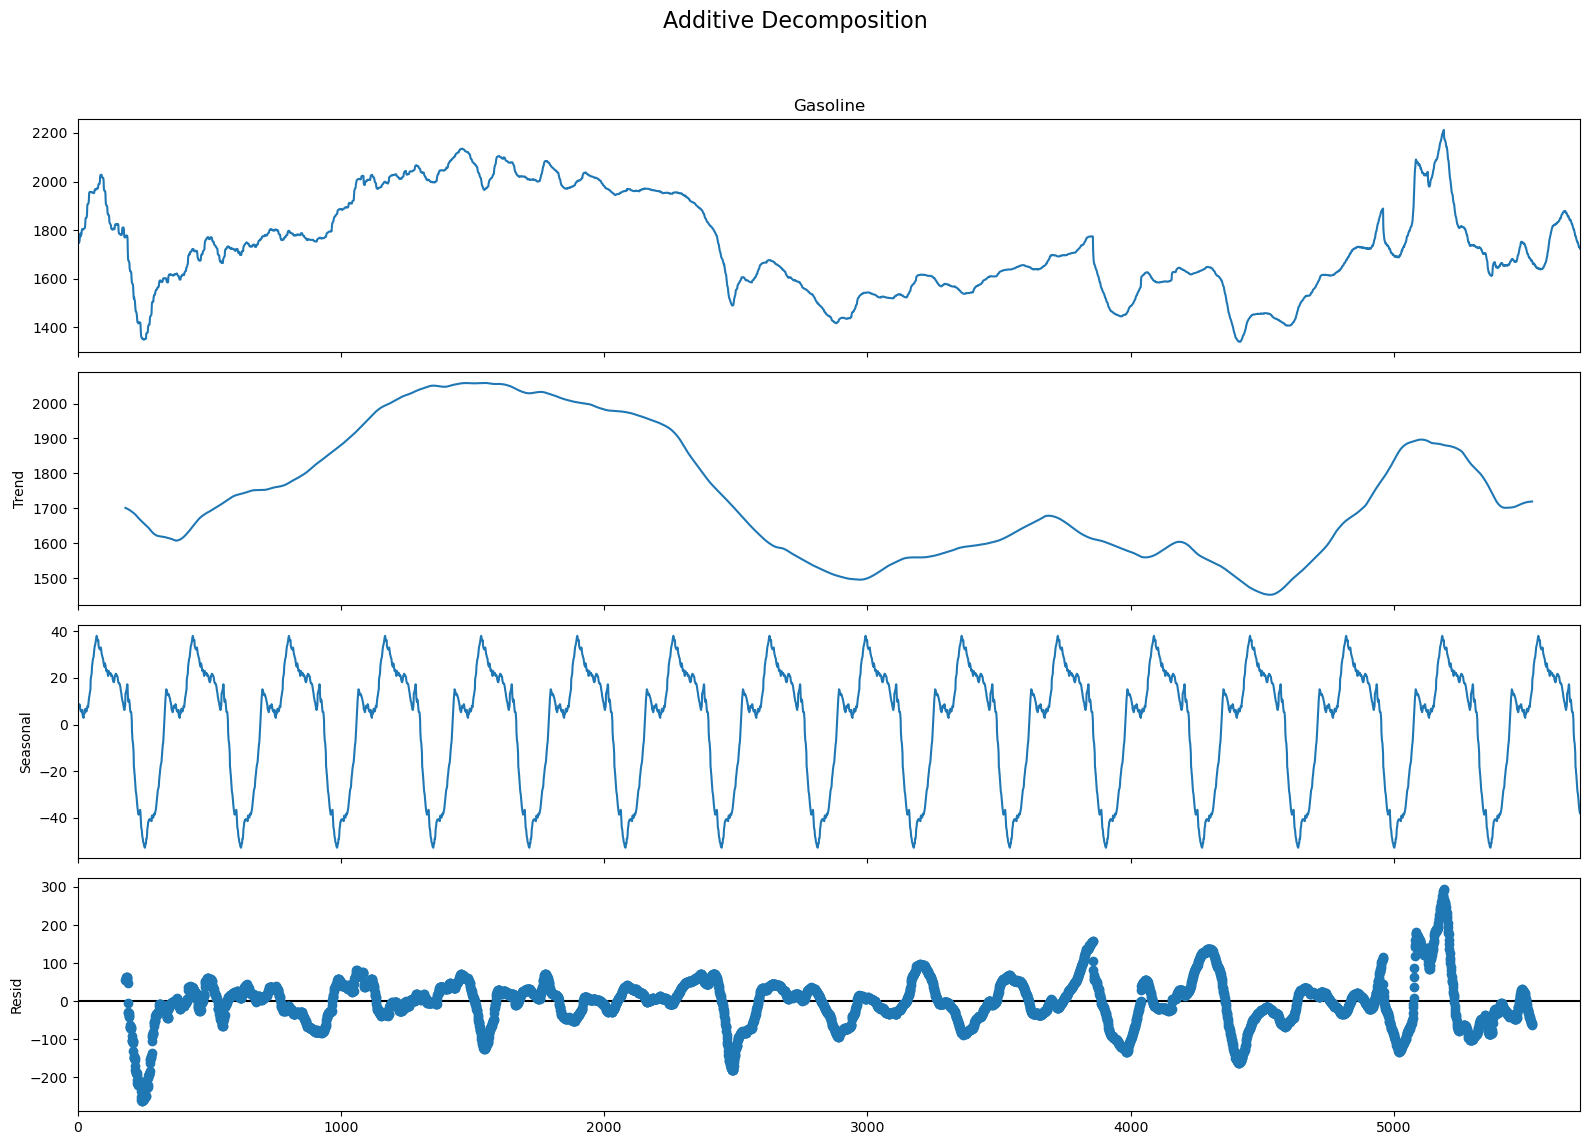

In [224]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(data['Gasoline'], model='multiplicative', period=365)

# Additive Decomposition
additive_decomposition = seasonal_decompose(data['Gasoline'], model='additive', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [226]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(data_brent['Brent'], model='multiplicative', period=365)

# Additive Decomposition
additive_decomposition = seasonal_decompose(data_brnet['Brent'], model='additive', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

In [225]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST 결과')
adf_test(data['Gasoline'])

ADF TEST 결과
ADF Statistics: -2.812807
p-value: 0.056468
num of lags: 22.000000
num of observations: 5684.000000
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [227]:
print('ADF TEST 결과')
adf_test(data_brent['Brent'])

ADF TEST 결과
ADF Statistics: -2.662807
p-value: 0.080698
num of lags: 31.000000
num of observations: 5675.000000
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


P value is 0.0572, which is greater than 0.05.
<br>
Thus, It is not significant, which means the data is $Non-Stationary$.
<br>
Although I doubt that this value means significant.

## Stationary and Non-Stationary Time Series

In [ ]:
data.head(3)

In [ ]:
data.columns

In [228]:
new_data = data[['Date', "Gasoline"]]
new_data.set_index("Date", inplace=True)

In [229]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5707 entries, 2008-04-15 to 2023-11-29
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Gasoline  5707 non-null   float64
dtypes: float64(1)
memory usage: 89.2 KB


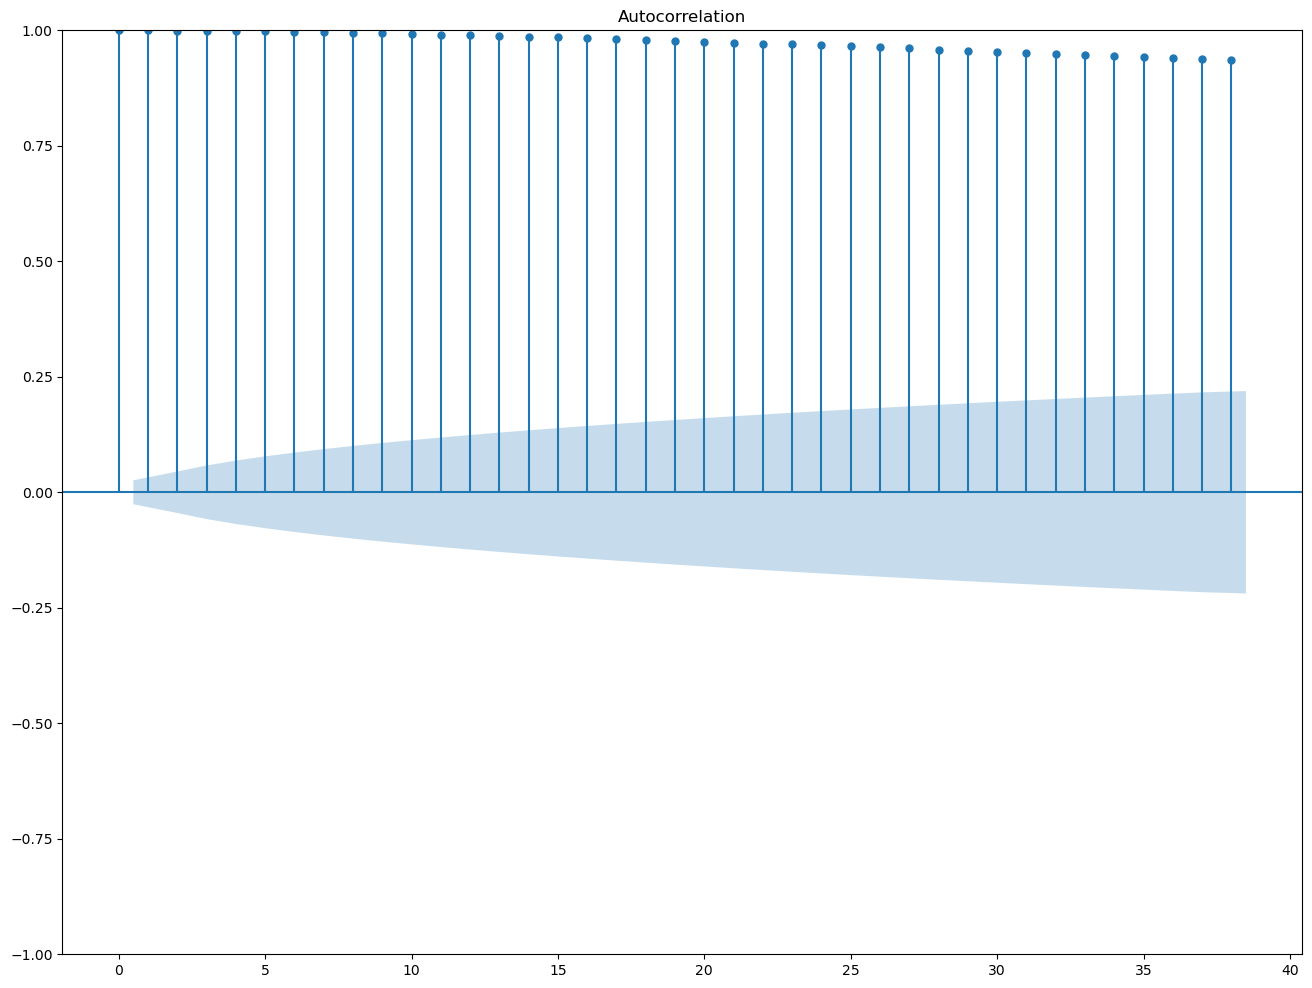

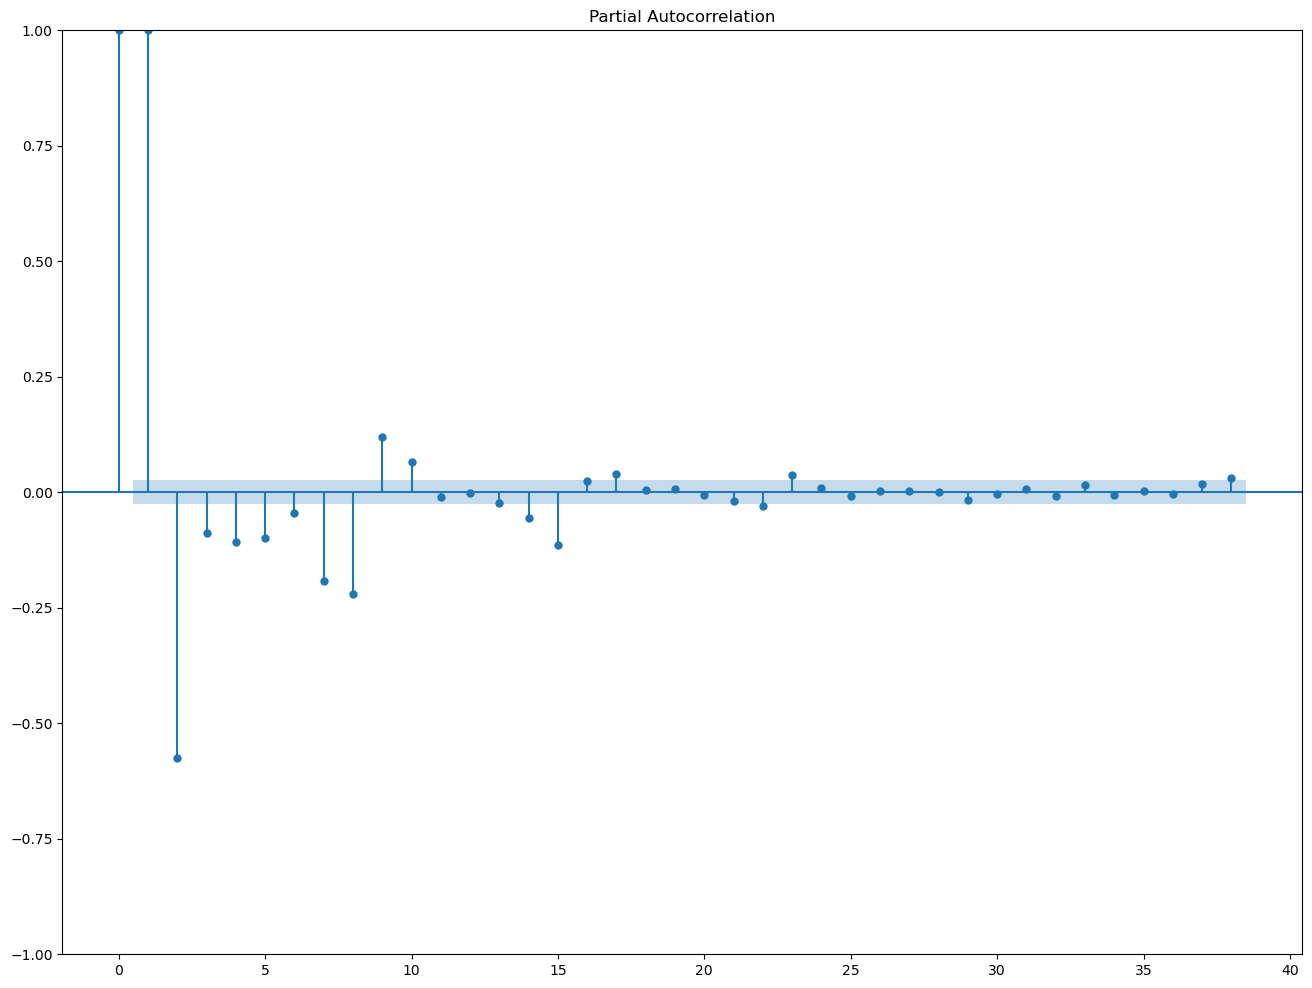

In [230]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(new_data)
plot_pacf(new_data)
plt.show()

ACF plot가 천천히 감소되는 것으로 보아 주식 데이터는 주기에 따라 일정하지 않은 비정상성 데이터이고,
<br>
PACF plot에서 첫값으로부터 1개 이후 파란 박스에 들어가면서 그래프가 끊기는 것으로 보아 AR(1) 모델을 활용하는 것이 가장 적절할 것으로 예상된다.

## NeuralProphet

In [231]:
neural = new_data.reset_index(drop=False)

neural.rename(columns = {'Date':'ds', 'Gasoline':'y'}, inplace = True)

In [232]:
neural

ds        y
0    2008-04-15  1734.58
1    2008-04-16  1749.97
2    2008-04-17  1744.71
3    2008-04-18  1748.01
4    2008-04-19  1748.87
...         ...      ...
5702 2023-11-25  1730.41
5703 2023-11-26  1729.95
5704 2023-11-27  1730.44
5705 2023-11-28  1727.37
5706 2023-11-29  1723.48

[5707 rows x 2 columns]

### 1. Train
- simple prophet
- a few year ago you had to set epoch, but now it automatically selects

In [233]:
m = NeuralProphet(quantiles=[0.05, 0.95])

m.set_plotting_backend("plotly")  # show plots correctly in jupyter notebooks

metrics = m.fit(neural, freq = "D")

Finding best initial lr:   0%|          | 0/244 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [239]:
forecast = m.predict(neural)

Predicting: 179it [00:00, ?it/s]

In [240]:
m.plot(forecast)

This is a simple model with a trend, a weekly seasonality and a yearly seasonality estimated by default. You can also look at the individual components separately as below.

In [236]:
m.plot_components(forecast)

In [241]:
m.plot_parameters()

### 2. Forecast Away

In [242]:
future = m.make_future_dataframe(neural, periods = 1095)
forecast = m.predict(future)
forecast.head()

Predicting: 179it [00:00, ?it/s]

ds     y        yhat1   yhat1 5.0%  yhat1 95.0%        trend  \
0 2023-11-30  None  1812.080322  1700.764526  2034.695312  1849.244141   
1 2023-12-01  None  1810.492310  1698.997070  2032.395264  1849.461060   
2 2023-12-02  None  1809.592407  1697.218994  2031.436523  1849.677979   
3 2023-12-03  None  1808.674316  1697.099609  2031.568604  1849.894897   
4 2023-12-04  None  1808.459717  1697.023315  2031.347656  1850.111694   

   season_yearly  season_weekly  
0     -37.466381       0.302486  
1     -38.592464      -0.376242  
2     -39.654224      -0.431297  
3     -40.649605      -0.571019  
4     -41.576950      -0.075138

In [243]:
forecast.tail()

ds     y        yhat1   yhat1 5.0%  yhat1 95.0%        trend  \
1090 2026-11-24  None  2056.312988  1970.246582  2371.918945  2085.642090   
1091 2026-11-25  None  2055.127441  1968.764893  2370.660400  2085.858887   
1092 2026-11-26  None  2053.661621  1968.259155  2369.384277  2086.075928   
1093 2026-11-27  None  2051.857422  1966.348389  2366.717285  2086.292725   
1094 2026-11-28  None  2050.729736  1964.418213  2365.365967  2086.509521   

      season_yearly  season_weekly  
1090     -29.887131       0.558118  
1091     -31.324722       0.593092  
1092     -32.716785       0.302486  
1093     -34.059299      -0.376242  
1094     -35.348537      -0.431297

In [244]:
m.plot(forecast)

---

### 1-1. Sophisticated Train
The individual coefficient values can also be plotted as below to gain further insights.

In [ ]:
m = NeuralProphet(n_lags=10, quantiles=[0.05, 0.95])
m.set_plotting_backend("plotly")
metrics = m.fit(neural, freq = "D")

In [ ]:
predicted = m.predict(neural)
forecast = m.predict(neural)

In [ ]:
m.highlight_nth_step_ahead_of_each_forecast(1).plot(forecast)

This Improved model seems overfitted

In [ ]:
plotcomp = m.plot_components(forecast)

#### NeuralProphet - other way

In [ ]:
ax = neural.set_index('ds').plot(figsize=(15, 12))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

9:1

In [ ]:
m1 = NeuralProphet()
m1.set_plotting_backend("plotly")

In [ ]:
train, val = m1.split_df(neural, valid_p = 0.1)

print("Dataset size:", len(neural))
print("Train dataset size:", len(train))
print("Validation dataset size:", len(val))

In [ ]:
metrics1 = m1.fit(train, validation_df = val, progress=None)
metrics1

In [ ]:
forecast1 = m1.predict(neural)
m1.plot(forecast1)

In [ ]:
fig_components = m1.plot_components(forecast1)
fig_components

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(metrics1["MAE"], '-o', label="Training Loss")  
ax.plot(metrics1["MAE_val"], '-r', label="Validation Loss")
ax.legend(loc='center right', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel("Epoch", fontsize=28)
ax.set_ylabel("Loss", fontsize=28)
ax.set_title("Model Loss (MAE)", fontsize=28)